In [1]:
# ------------------------------------------------------
import numpy as np
import pandas as pd
import os
import gc
import warnings

# ------------------------------------------------------
import statsmodels.api as sm

# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


In [2]:
# Import
train = pd.read_csv("data/store-sales-time-series-forecasting/train.csv")
test = pd.read_csv("data/store-sales-time-series-forecasting/test.csv")
stores = pd.read_csv("data/store-sales-time-series-forecasting/stores.csv")
#sub = pd.read_csv("../input/store-sales-time-series-forecasting/sample_submission.csv")   
transactions = pd.read_csv("data/store-sales-time-series-forecasting/transactions.csv").sort_values(["store_nbr", "date"])


# Datetime
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)

# Data types
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


In [3]:
transactions.head(10)

,date,store_nbr,transactions
1,2013-01-02,1,2111
47,2013-01-03,1,1833
93,2013-01-04,1,1863
139,2013-01-05,1,1509
185,2013-01-06,1,520
231,2013-01-07,1,1807
277,2013-01-08,1,1869
323,2013-01-09,1,1910
369,2013-01-10,1,1679
415,2013-01-11,1,1813


Transactions refer to the number of individuals who visited the store or the quantity of invoices generated within a day.

Sales represent the number of sales generated from a specific product category within a particular store on a specified date. It is important to note that fractional values are feasible due to the possibility of products being sold in fractional units (such as 1.5 kg of cheese, rather than whole units like 1 bag of chips).

<Axes: >

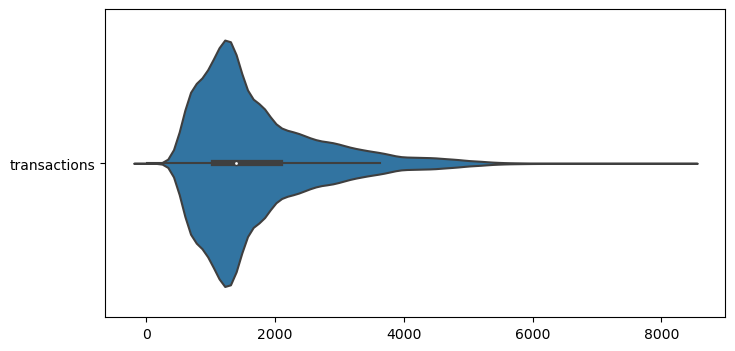

In [4]:
transac = pd.DataFrame(transactions['transactions'])
f = plt.figure(figsize=(8, 4))
sb.violinplot(data = transac, orient = "h")

we use a violin plot to visualize the distribution of the monthly average number of transactions from all stores from 2013 to 2017. We can see the monthly average number of transactions for a store is around 1694 transactions.

In [5]:
transac.describe()

,transactions
count,83488.000000
mean,1694.602158
std,963.286644
min,5.000000
25%,1046.000000
50%,1393.000000
75%,2079.000000
max,8359.000000


In [6]:
a = transactions.set_index("date").resample("M").transactions.mean().reset_index()
a["year"] = a.date.dt.year
a

,date,transactions,year
0,2013-01-31,1657.898624,2013
1,2013-02-28,1684.483696,2013
2,2013-03-31,1724.181627,2013
3,2013-04-30,1699.206522,2013
4,2013-05-31,1702.874396,2013
5,2013-06-30,1701.426743,2013
6,2013-07-31,1675.012552,2013
7,2013-08-31,1689.182567,2013
8,2013-09-30,1688.270922,2013
9,2013-10-31,1653.013040,2013


In [7]:
#add a "month" column to the dataframe
sr = pd.to_datetime(a['date']) 
result = sr.dt.month_name(locale = 'English') 

In [8]:
a2 = a.assign(month=result)
a2

,date,transactions,year,month
0,2013-01-31,1657.898624,2013,January
1,2013-02-28,1684.483696,2013,February
2,2013-03-31,1724.181627,2013,March
3,2013-04-30,1699.206522,2013,April
4,2013-05-31,1702.874396,2013,May
5,2013-06-30,1701.426743,2013,June
6,2013-07-31,1675.012552,2013,July
7,2013-08-31,1689.182567,2013,August
8,2013-09-30,1688.270922,2013,September
9,2013-10-31,1653.013040,2013,October


In [9]:
a2.dtypes

date            datetime64[ns]
transactions           float64
year                     int32
month                   object
dtype: object

In [10]:
#monthly average transactions for 2013
a2013 = a2.loc[a['year'] == 2013]
a2013

,date,transactions,year,month
0,2013-01-31,1657.898624,2013,January
1,2013-02-28,1684.483696,2013,February
2,2013-03-31,1724.181627,2013,March
3,2013-04-30,1699.206522,2013,April
4,2013-05-31,1702.874396,2013,May
5,2013-06-30,1701.426743,2013,June
6,2013-07-31,1675.012552,2013,July
7,2013-08-31,1689.182567,2013,August
8,2013-09-30,1688.270922,2013,September
9,2013-10-31,1653.013040,2013,October


In [11]:
#monthly average transactions for each year
a2014 = a2.loc[a['year'] == 2014]
a2015 = a2.loc[a['year'] == 2015]
a2016 = a2.loc[a['year'] == 2016]
a2017 = a2.loc[a['year'] == 2017]

### number of monthly average transactions for each year

<Axes: xlabel='month', ylabel='transactions'>

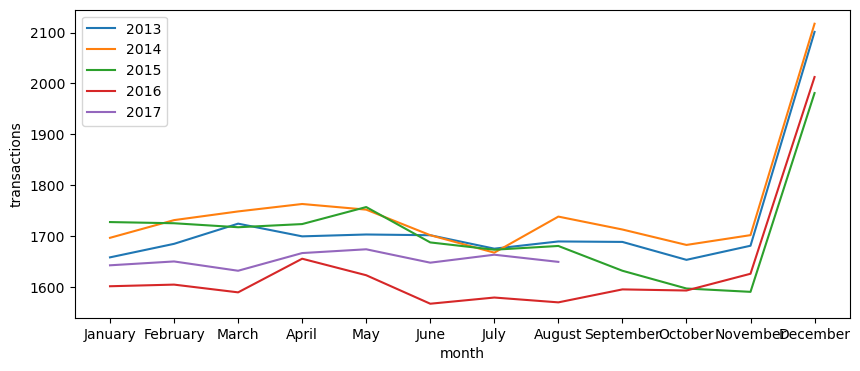

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 4))
    
sb.lineplot(data=a2013, x="month", y="transactions", ax=ax, label="2013")
sb.lineplot(data=a2014, x="month", y="transactions", ax=ax, label="2014")
sb.lineplot(data=a2015, x="month", y="transactions", ax=ax, label="2015")
sb.lineplot(data=a2016, x="month", y="transactions", ax=ax, label="2016")
sb.lineplot(data=a2017, x="month", y="transactions", ax=ax, label="2017")

It seems that there is a pattern with the number of transactions increasing at the end of the year in  December.

### Which product category sells the most items? 

The graph shows us GROCERY I, BEVERAGES, and PRODUCE are the top 3 selling categories among the grocery stores.

In [13]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0.0
1,1,2013-01-01,1,BABY CARE,0.000000,0.0
2,2,2013-01-01,1,BEAUTY,0.000000,0.0
3,3,2013-01-01,1,BEVERAGES,0.000000,0.0
4,4,2013-01-01,1,BOOKS,0.000000,0.0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.132996,0.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.552994,1.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729004,148.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8.0


<Axes: xlabel='sales', ylabel='family'>

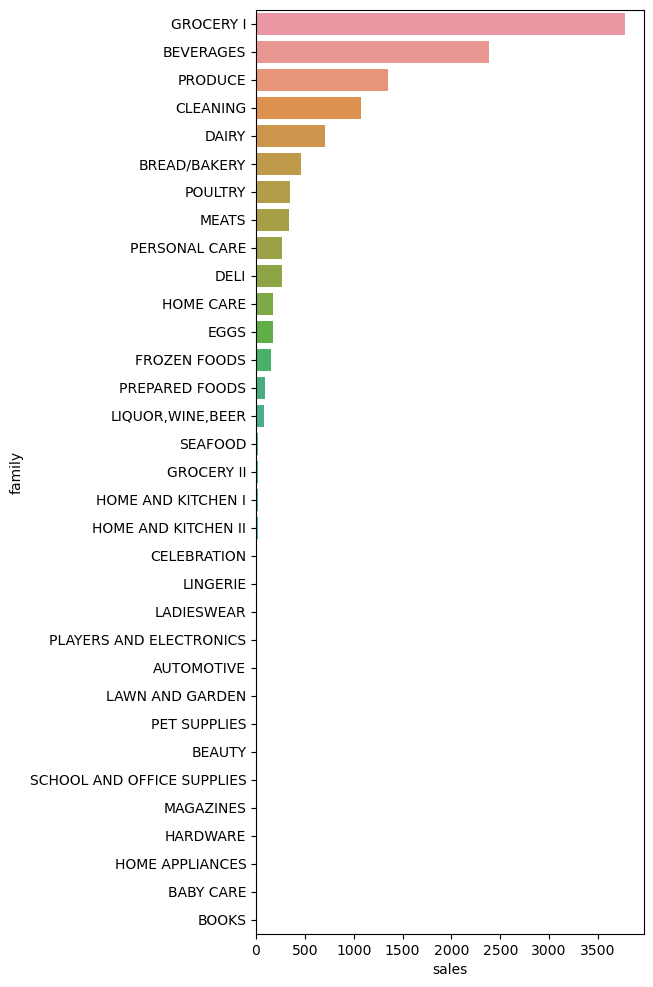

In [14]:
a = train.groupby("family").sales.mean().sort_values(ascending = False).reset_index()
a

fig, ax = plt.subplots(figsize=(5, 12))
sb.barplot(x=a.sales, y=a.family, orient='h')

### What is a Time Series?

The basic object of forecasting is the time series, which is a set of observations recorded over time. In forecasting applications, the observations are typically recorded with a regular frequency, like daily or monthly.

In [15]:
def grouped(df, key, freq, col):
    #group data with certain frequency
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

In [16]:
df_grouped_train_w = grouped(train, 'date', 'W', 'sales')
df_grouped_train_w

,date,mean
0,2013-01-06,206.843475
1,2013-01-13,190.285217
2,2013-01-20,189.835464
3,2013-01-27,182.152054
4,2013-02-03,198.564270
...,...,...
237,2017-07-23,460.504639
238,2017-07-30,474.732391
239,2017-08-06,513.884338
240,2017-08-13,431.730164


In [17]:
df_grouped_train_w = df_grouped_train_w.set_index("date")
df = df_grouped_train_w.copy()
df['Time'] = np.arange(len(df_grouped_train_w.index))
df.head()

,mean,Time
date,,
2013-01-06,206.843475,0
2013-01-13,190.285217,1
2013-01-20,189.835464,2
2013-01-27,182.152054,3
2013-02-03,198.564270,4


In [18]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'mean']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

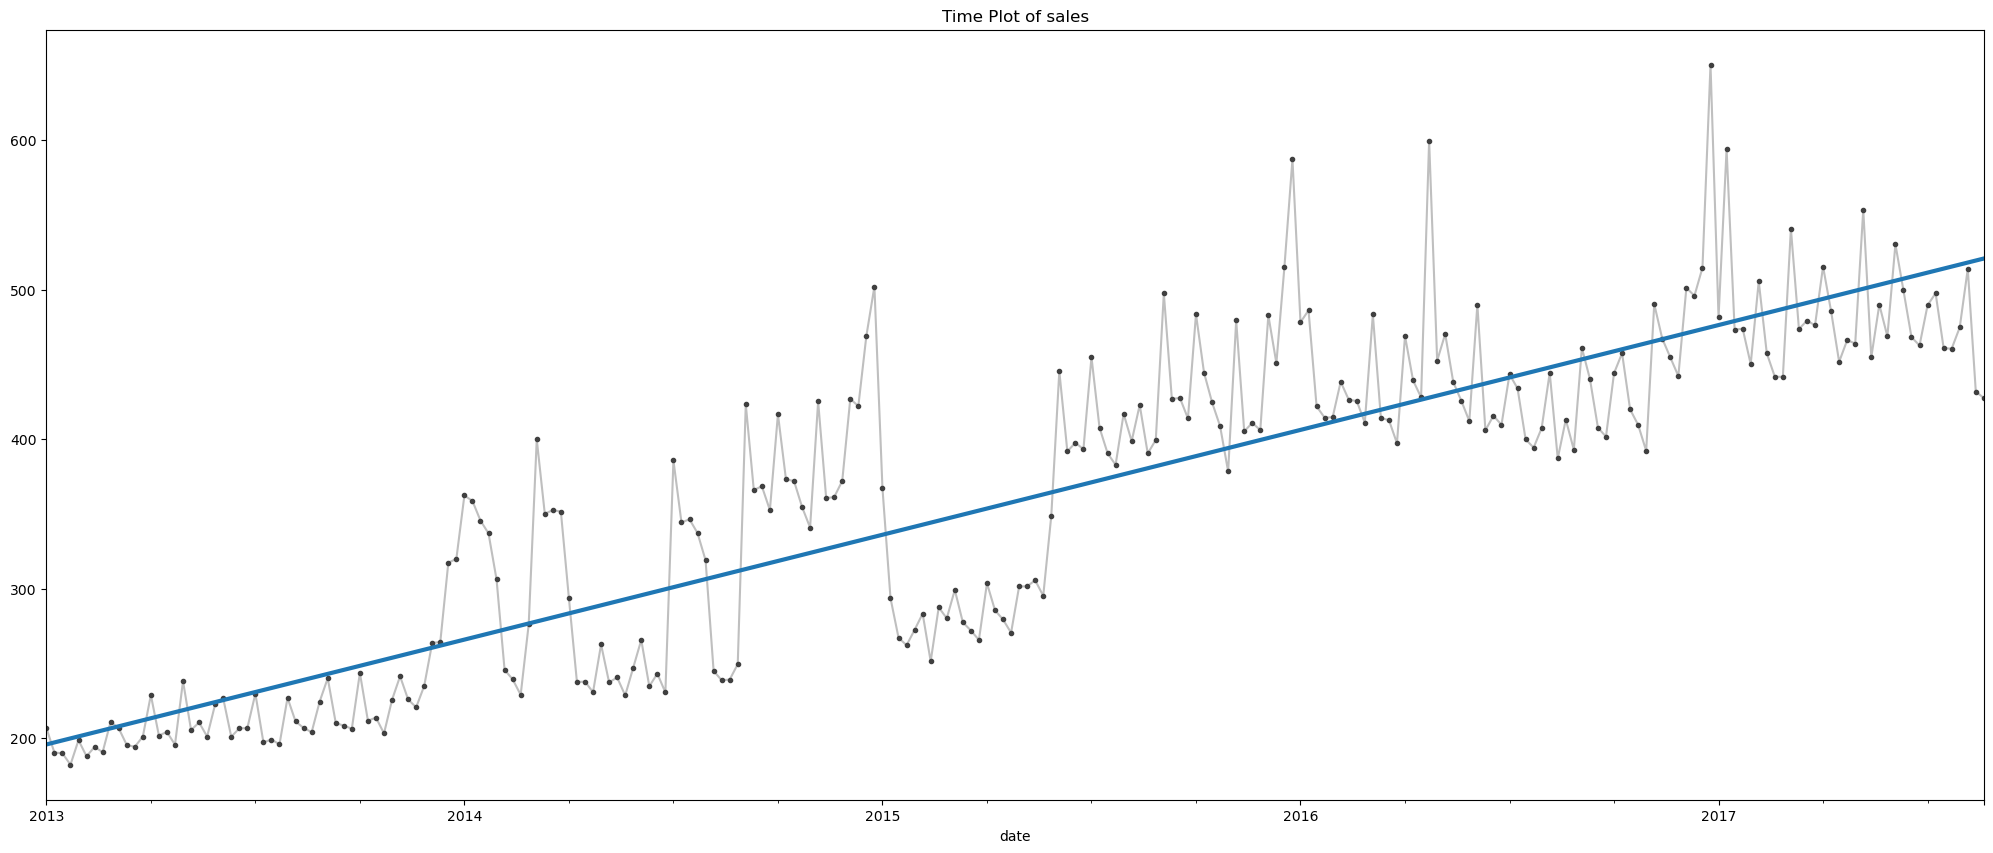

In [19]:
fig, axes = plt.subplots(figsize=(25,10))
ax = y.plot(color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of sales');

In [20]:
df_grouped = grouped(train, 'date', 'W', 'sales')
df_grouped

,date,mean
0,2013-01-06,206.843475
1,2013-01-13,190.285217
2,2013-01-20,189.835464
3,2013-01-27,182.152054
4,2013-02-03,198.564270
...,...,...
237,2017-07-23,460.504639
238,2017-07-30,474.732391
239,2017-08-06,513.884338
240,2017-08-13,431.730164


### What is Trend?
The trend component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. In a time series of product sales, an increasing trend might be the effect of a market expansion as more people become aware of the product year by year.

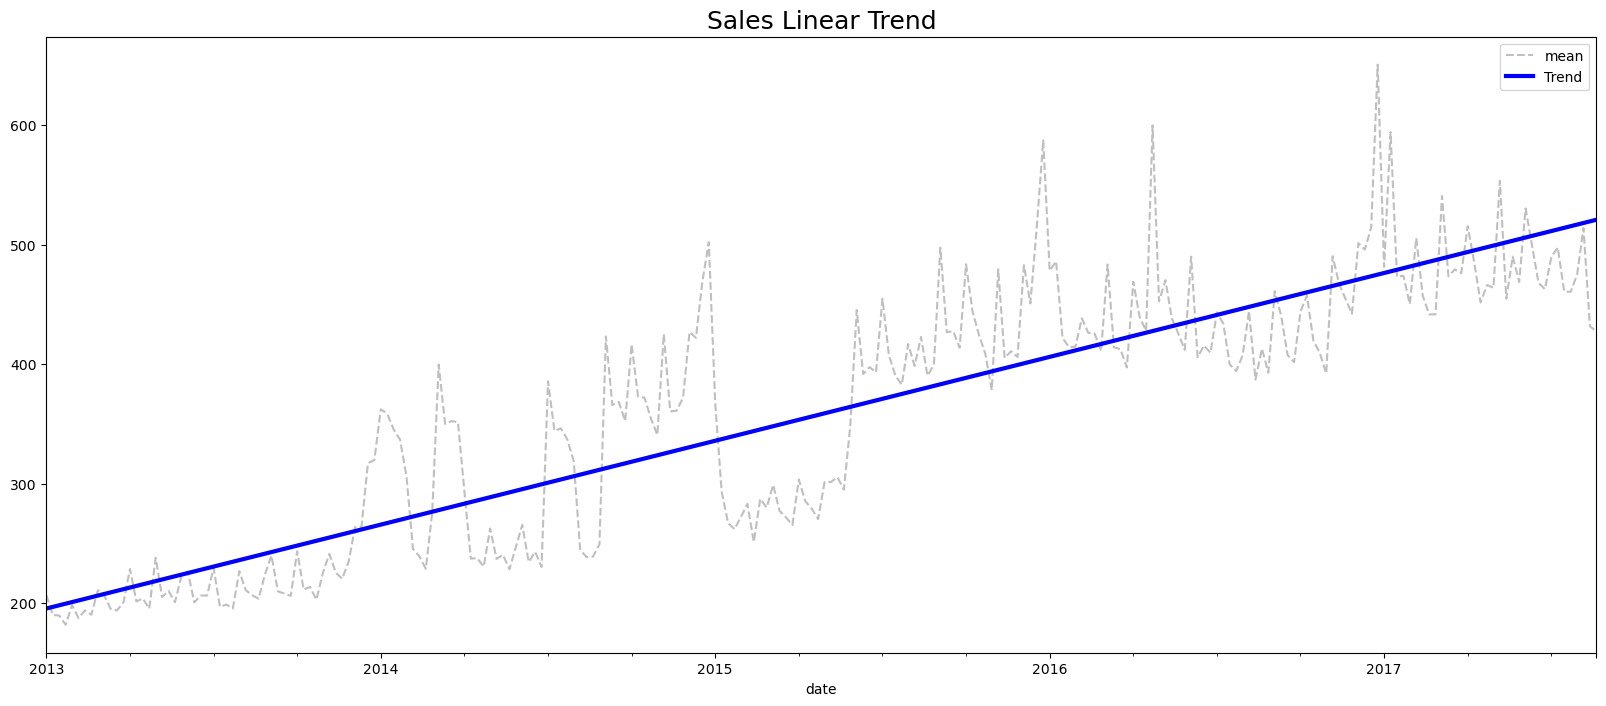

In [21]:
fig, axes = plt.subplots(figsize=(20,8))

df_grouped['date'] = pd.to_datetime(df_grouped['date'], format = "%Y-%m-%d") 
dp = DeterministicProcess(index=df_grouped['date'], constant=True, order=1, drop=True)
dp.index.freq = 'W' # manually set the frequency of the index
# 'in_sample' creates features for the dates given in the `index` argument
X1 = dp.in_sample()
y1 = df_grouped["mean"]  # the target
y1.index = X1.index
# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X1, y1)
y1_pred = pd.Series(model.predict(X1), index=X1.index)
ax1 = y1.plot(linestyle='dashed', label="mean", color="0.75")
ax1 = y1_pred.plot(linewidth=3, label="Trend", color='b')
ax1.set_title("Sales Linear Trend", fontsize=18)  
_ = ax1.legend()

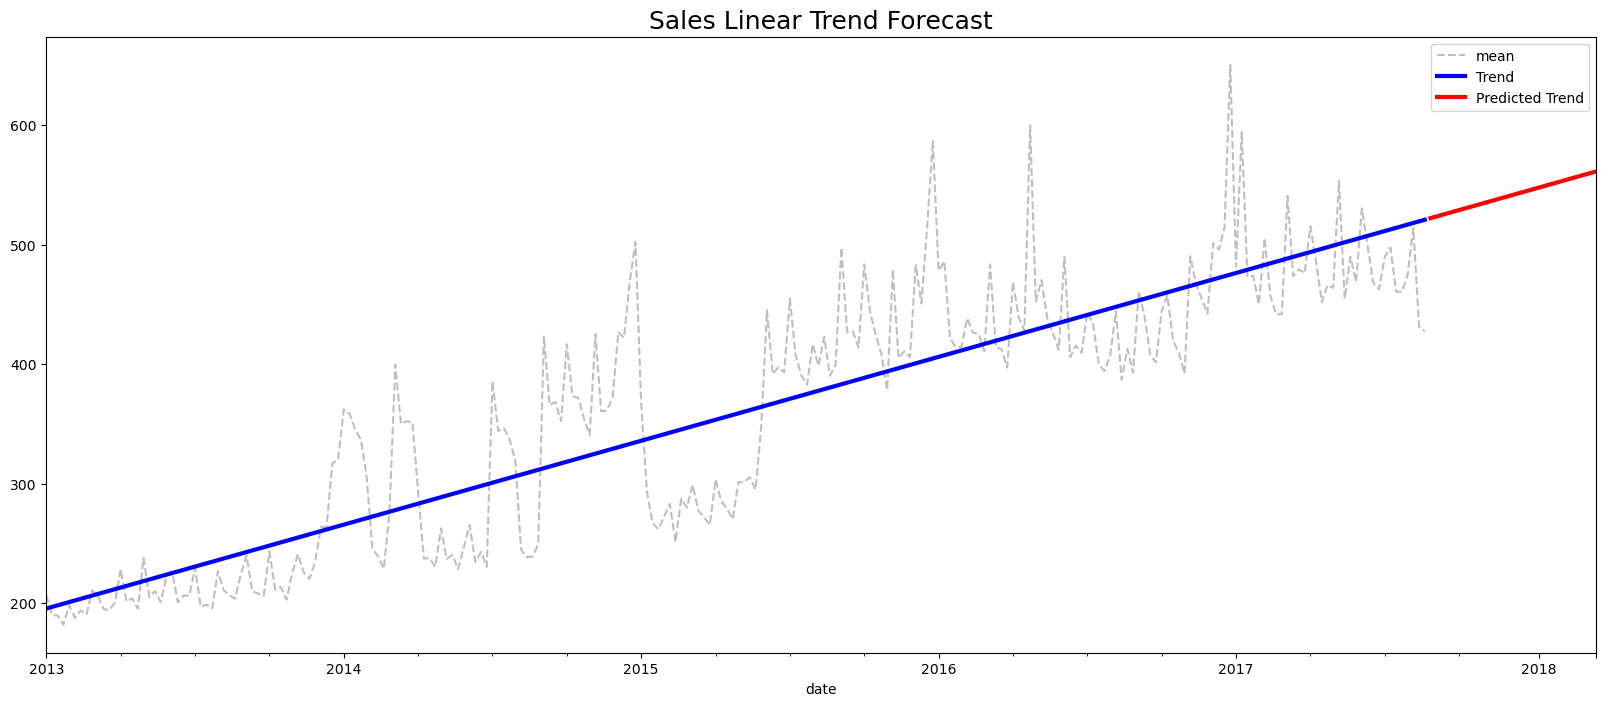

In [22]:
fig, axes = plt.subplots(figsize=(20,8))

steps = 30 
X2 = dp.out_of_sample(steps=30)
y2_fore = pd.Series(model.predict(X2), index=X2.index)
y2_fore.head()
ax2 = y1.plot(linestyle='dashed', label="mean", color="0.75")
ax2 = y1_pred.plot(linewidth=3, label="Trend", color='b')
ax2 = y2_fore.plot(linewidth=3, label="Predicted Trend", color='r')
ax2.set_title("Sales Linear Trend Forecast", fontsize=18)  
_ = ax2.legend()

Besides acting as a baseline or starting point for more sophisticated models, this trend model can be useful for a number of reasons as it shows us a rough forecast of the sales.

### Seasonality
Time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times. Just like we used a moving average plot to discover the trend in a series, we can use a seasonal plot to discover seasonal patterns.

In [23]:
def predict_seasonality(df, key, freq, col, ax1, title1):
    fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality
    df_grouped = grouped(df, key, freq, col)
    df_grouped['date'] = pd.to_datetime(df_grouped['date'], format = "%Y-%m-%d") 
    df_grouped['date'].freq = freq # manually set the frequency of the index
    dp = DeterministicProcess(index=df_grouped['date'], 
                              constant=True, 
                              order=1, 
                              period=None, 
                              seasonal=True, 
                              additional_terms=[fourier], 
                              drop=True)
    dp.index.freq = freq # manually set the frequency of the index

    # 'in_sample' creates features for the dates given in the `index` argument
    X1 = dp.in_sample()
    y1 = df_grouped["mean"]  # the target
    y1.index = X1.index

    # The intercept is the same as the `const` feature from
    # DeterministicProcess. LinearRegression behaves badly with duplicated
    # features, so we need to be sure to exclude it here.
    model = LinearRegression(fit_intercept=False)
    model.fit(X1, y1)
    y1_pred = pd.Series(model.predict(X1), index=X1.index)
    X1_fore = dp.out_of_sample(steps=90)
    y1_fore = pd.Series(model.predict(X1_fore), index=X1_fore.index)
    
    ax1 = y1.plot(linestyle='dashed', style='.', label="init mean values", color="0.4", ax=ax1, use_index=True)
    ax1 = y1_pred.plot(linewidth=3, label="Seasonal", color='b', ax=ax1, use_index=True)
    ax1 = y1_fore.plot(linewidth=3, label="Seasonal Forecast", color='r', ax=ax1, use_index=True)
    ax1.set_title(title1, fontsize=18)  
    _ = ax1.legend()

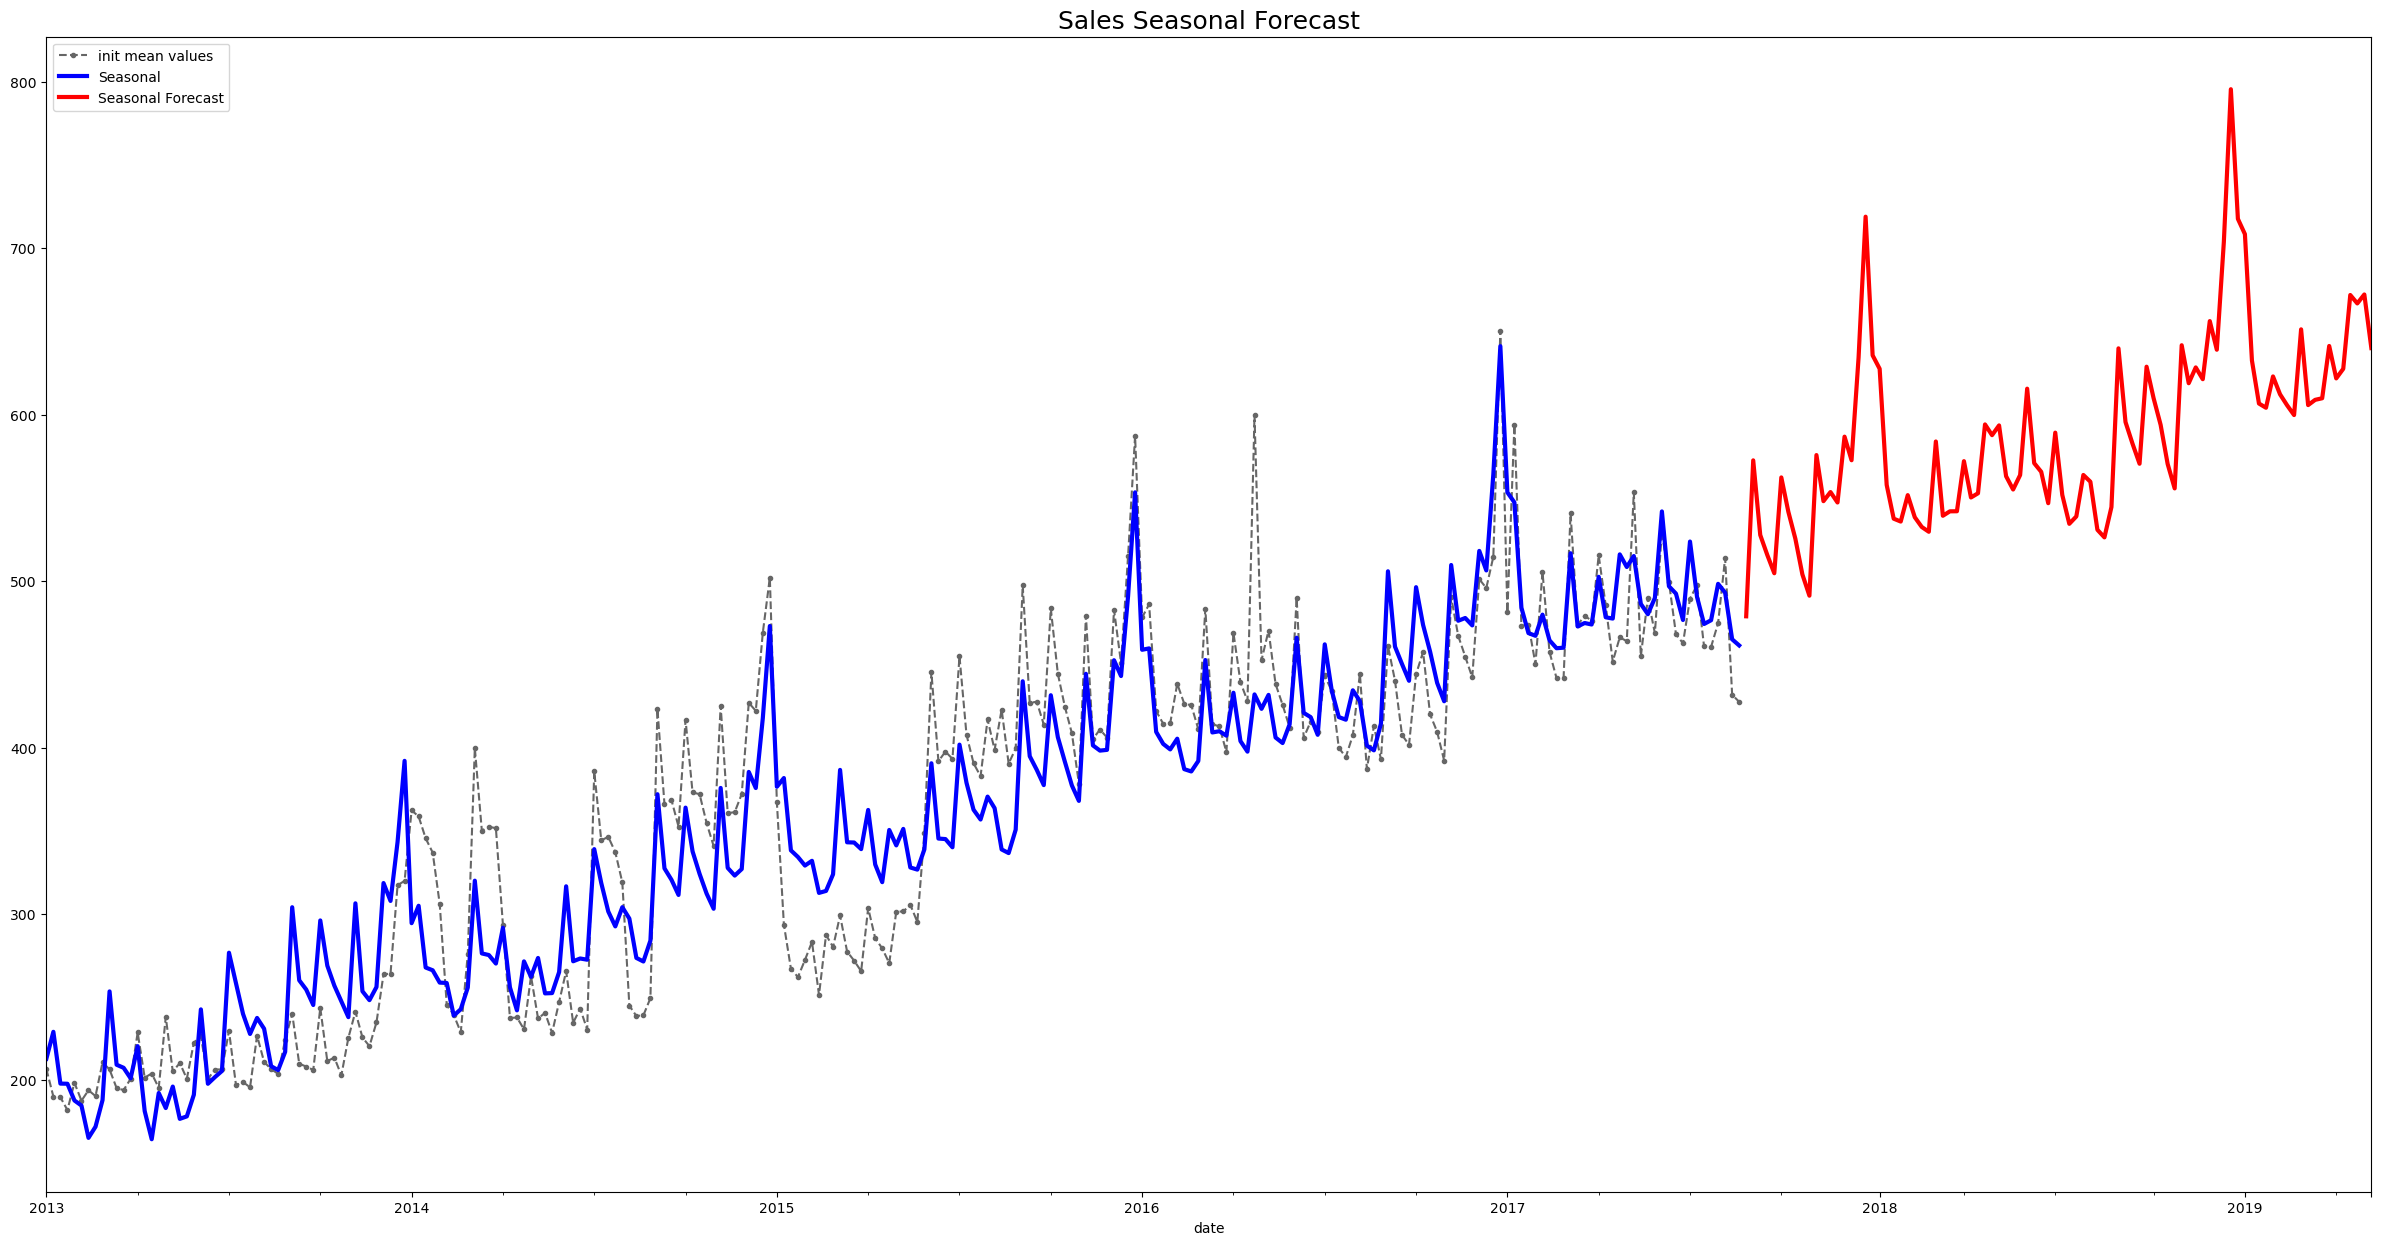

In [24]:
fig, axes = plt.subplots(figsize=(30,15))
predict_seasonality(train, 'date', 'W', 'sales', axes, "Sales Seasonal Forecast")
plt.show()